<a href="https://colab.research.google.com/github/u-10bei/Population_Projections/blob/main/ipynb/R_ARIMA_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ライブラリインストール
install.packages( "tidyverse" )
install.packages( "fable" )
install.packages( "feasts" )
install.packages( "urca" )
install.packages( "reshape2" )

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘BH’, ‘progressr’, ‘anytime’, ‘numDeriv’, ‘fabletools’, ‘Rcpp’, ‘tsibble’, ‘distributional’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘warp’, ‘slider’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘plyr’




目的：日本の将来人口を、Ｒを使って推計してみます。  
　　　今回は人口方程式の考え方に沿って時系列分析します。  
　　　ただし、死亡数は年齢３区分ごとに、一旦死亡率を求め計算します。

>$t$年から$a$年後の人口$(P_{t+a})$は、基準人口$(P_t)$に$t$年から$t+a$年までの  
出生数$(B)$を加え死亡数$(D)$を減じ  
国籍取得数$(IN)$を加え国籍離脱数$(ON)$を減じたものです。  
$P_{t+a}={P_t}+{B_{t\to t+a}}－{D_{t\to t+a}}$
$+{IN_{t\to t+a}}-{ON_{t\to t+a}}$  

# 手順１　データの収集


*　[データ保存場所](https://raw.githubusercontent.com/u-10bei/Population_Projections/main/population_jp_year.csv)
*  各年１０月１日人口： [「人口推計」（総務省統計局）](https://www.stat.go.jp/data/jinsui/2.html)を加工して作成しました。
*  出生・死亡 [「人口動態調査」（厚生労働省）](https://www.mhlw.go.jp/toukei/list/81-1a.html)を加工して作成しました。


データを読み込んで、時系列予測に必要な形式に変換します。  
データサイエンスの便利ツール[tidyverse](https://tidyverse.org/)や、  
時系列分析の便利ツール[tidyverts](https://tidyverts.org/)のパッケージを使います。

In [ ]:
# 該当リポジトリを変数に格納
repo = 
  c( "https://raw.githubusercontent.com/u-10bei/Population_Projections/" )

# 人口推計に使うデータの格納場所を変数に格納
popURL = 
  c( "main/data/population_jp_year.csv" )

# ライブラリの読み込み
library( readr )
library( fable )
library( dplyr )

# ネット上のファイル読み込み
repo |>
  paste0( popURL ) |>                     # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) |>           # ＴＳＩＢＢＬＥライブラリに変換
  mutate( Dr = Death / Total,             # 年代別の死亡率計算
          Dru14 = Du14 / Tu14,
          Drm = Dm / Tm,
          Dro65 = Do65 / To65 ) ->
pop_tsibble4

# 手順２　データの可視化

まず、データをプロットしてみます。

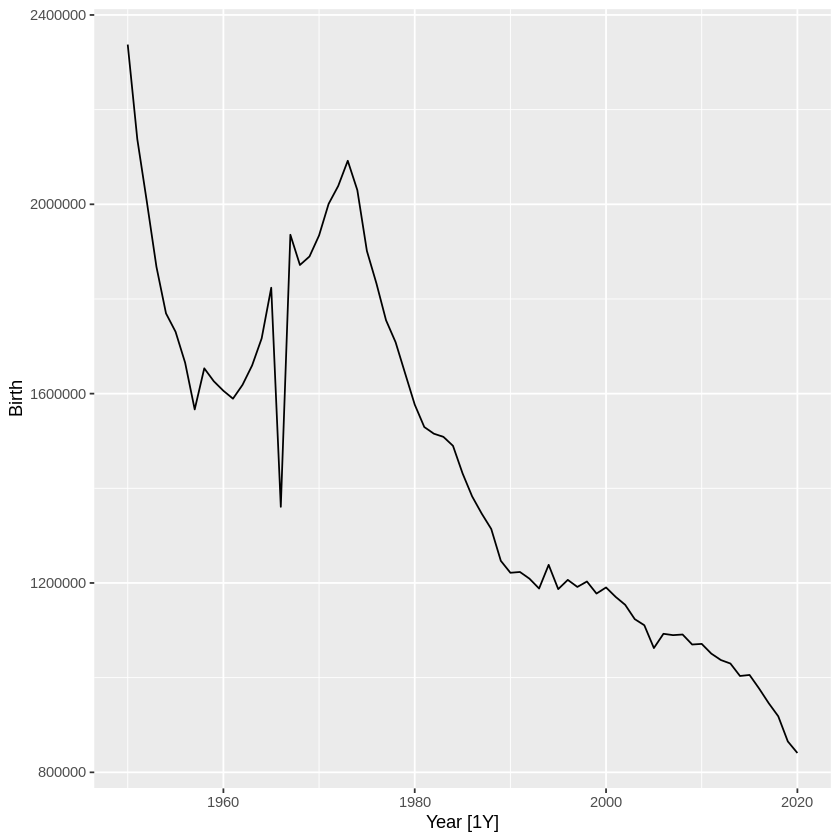

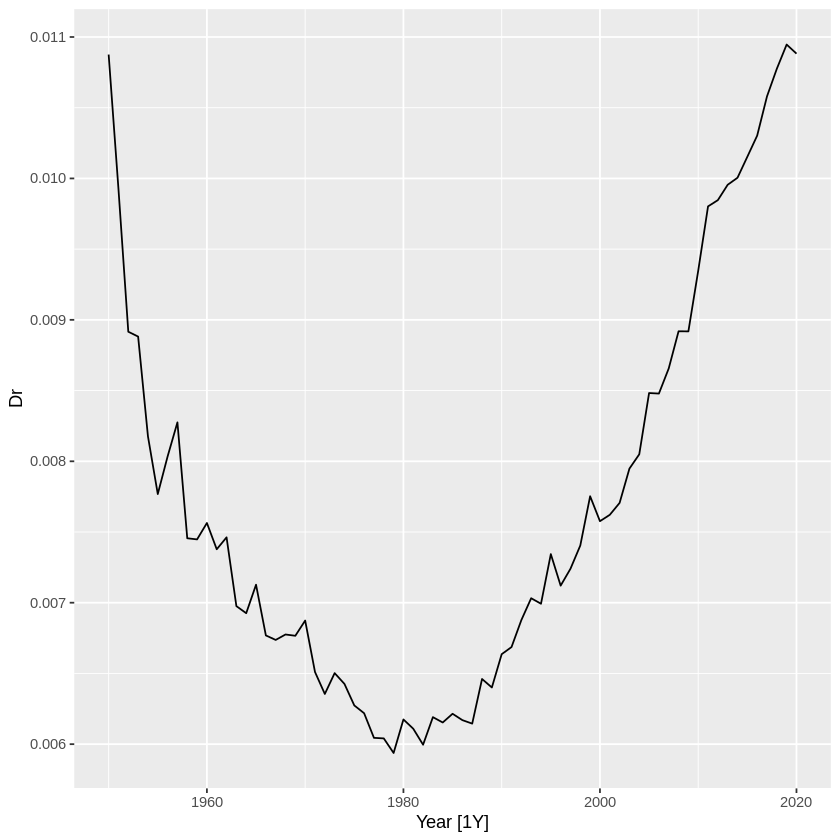

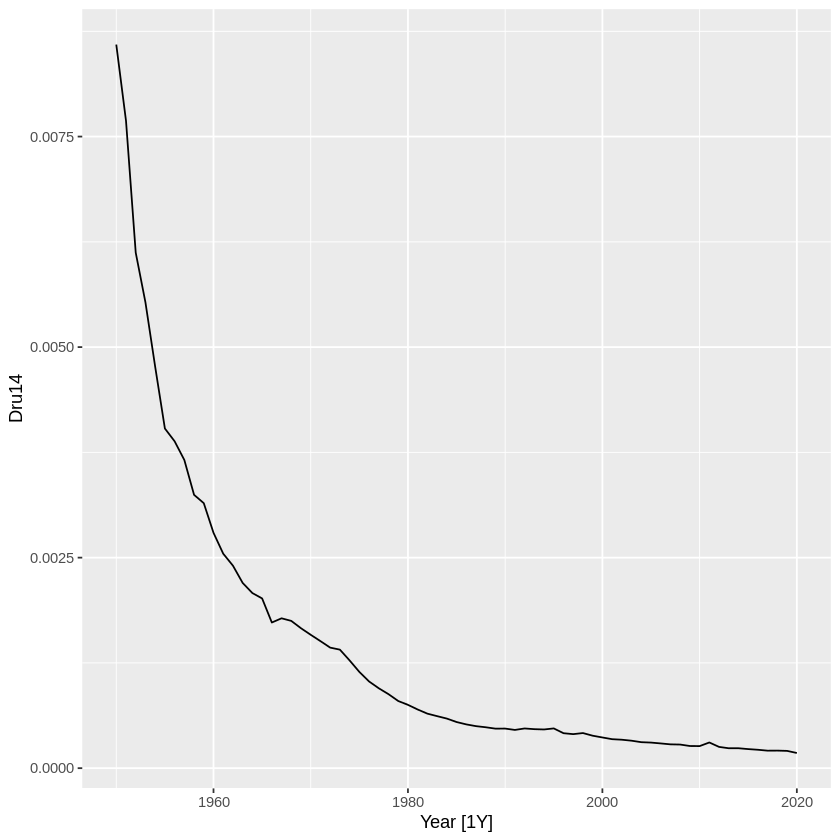

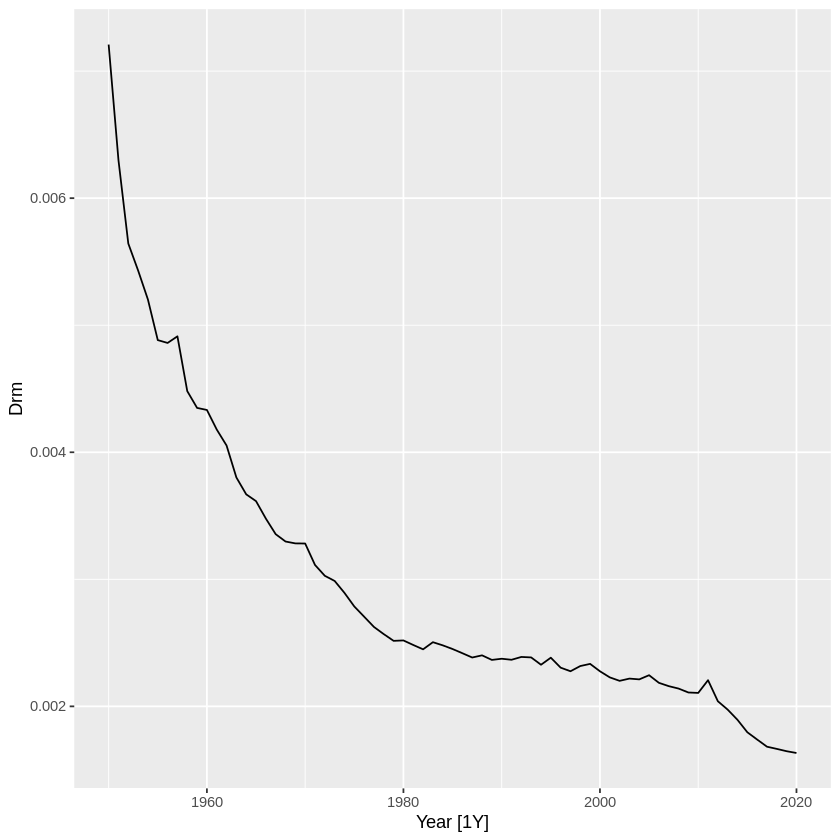

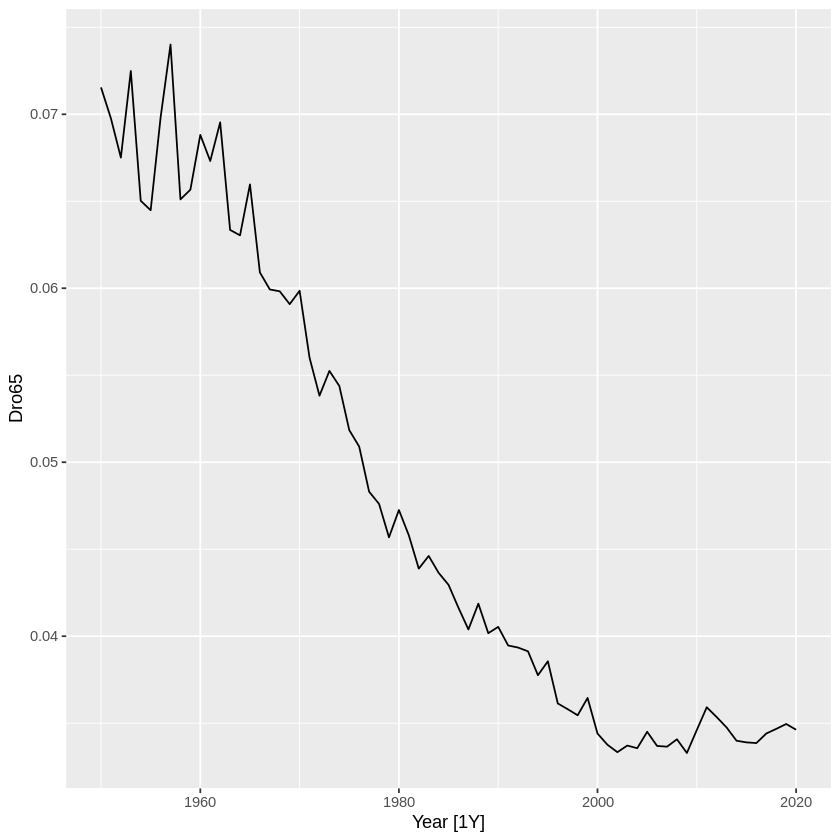

In [ ]:
# ライブラリの読み込み
library( ggplot2 )

# 出生数、死亡率のグラフ
pop_tsibble4 |>
  autoplot( Birth )
pop_tsibble4 |>
  autoplot( Dr )
pop_tsibble4 |>
  autoplot( Dru14 )
pop_tsibble4 |>
  autoplot( Drm )
pop_tsibble4 |>
  autoplot( Dro65 )

全体の死亡率が１９９０年代を境に上昇しているのに対し、  
年齢３区分で分類すると、死亡率はいずれも低下している事が分かります。  
次に、自己相関を確認してみます。

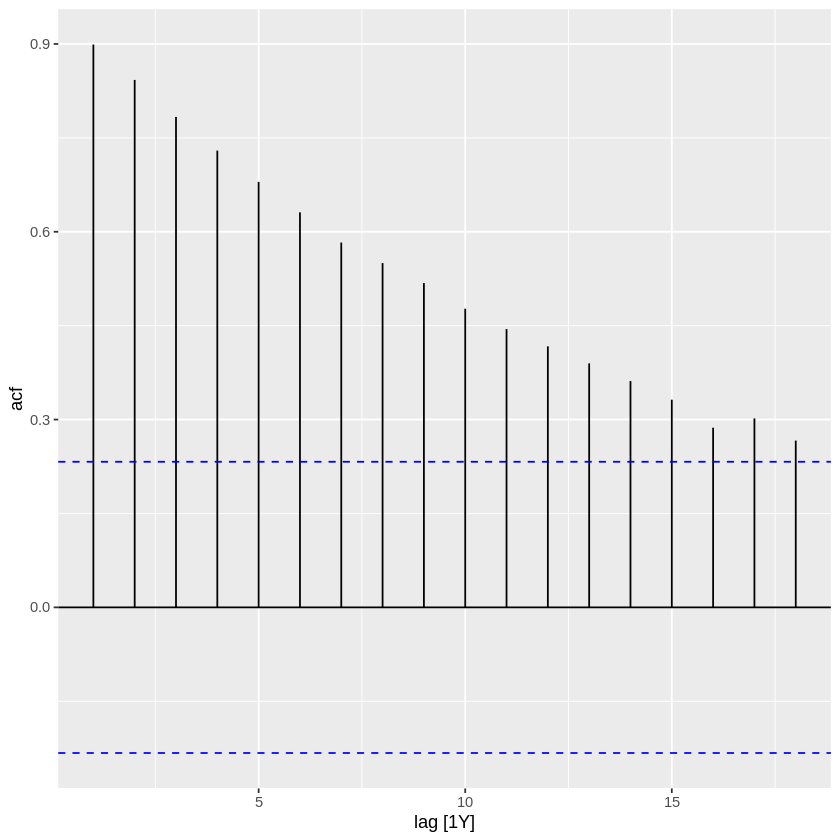

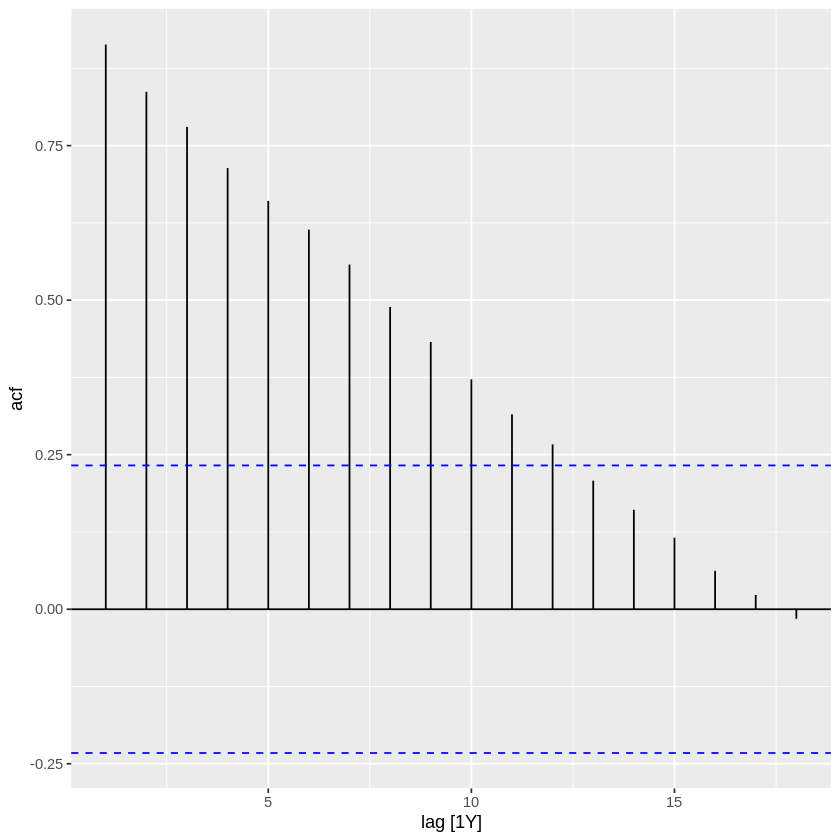

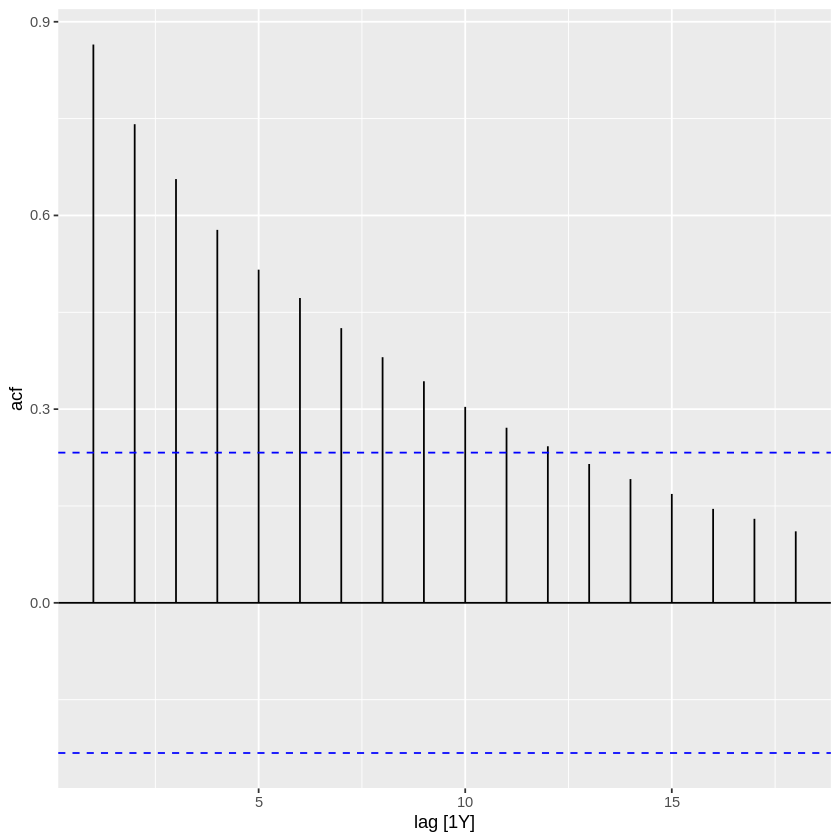

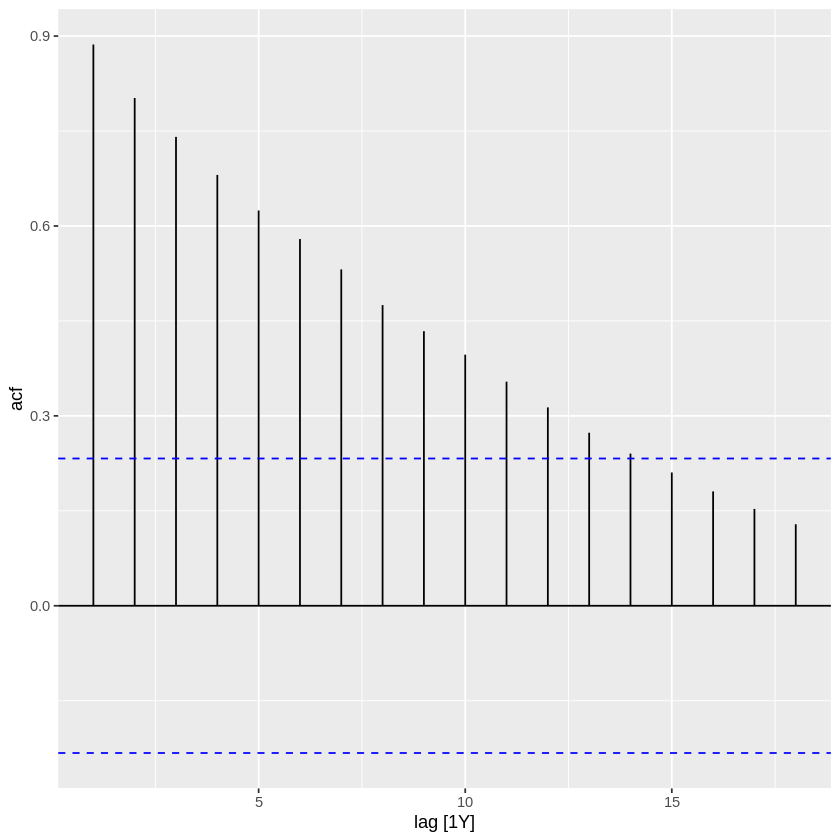

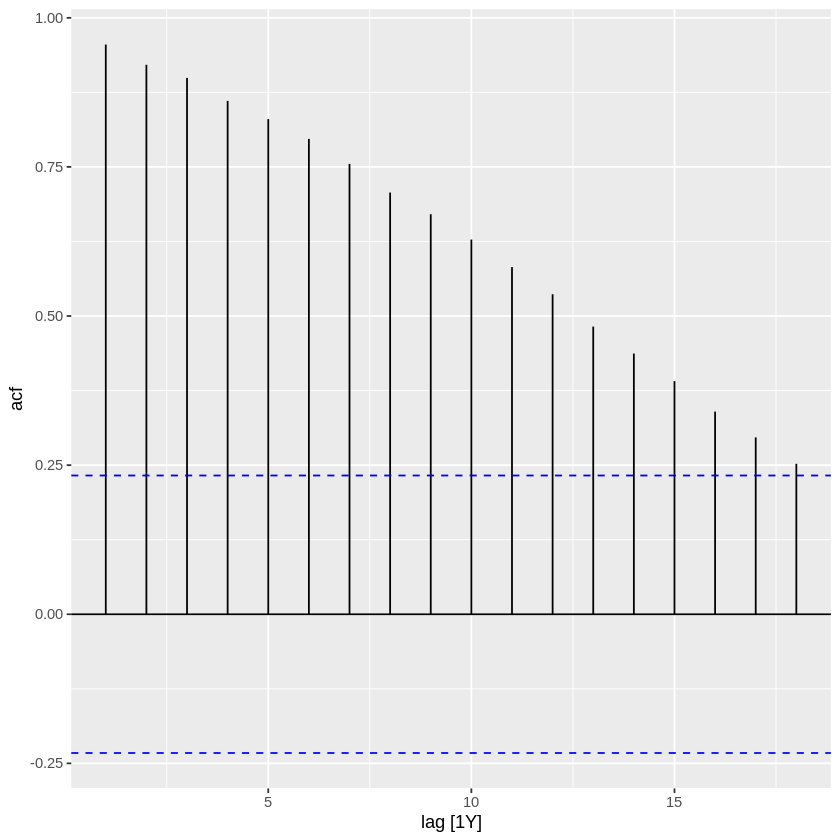

In [ ]:
# ライブラリの読み込み
library( feasts )

# 自己相関のグラフ
pop_tsibble4 |>
  ACF( Birth ) |>
  autoplot()
pop_tsibble4 |>
  ACF( Dr ) |>
  autoplot()
pop_tsibble4 |>
  ACF( Dru14 ) |>
  autoplot()
pop_tsibble4 |>
  ACF( Drm ) |>
  autoplot()
pop_tsibble4 |>
  ACF( Dro65 ) |>
  autoplot()

なんとなく相関はありそう。かつ、１年前のデータとの強い相関がありそうです。  
偏自己相関も確認しておきます。

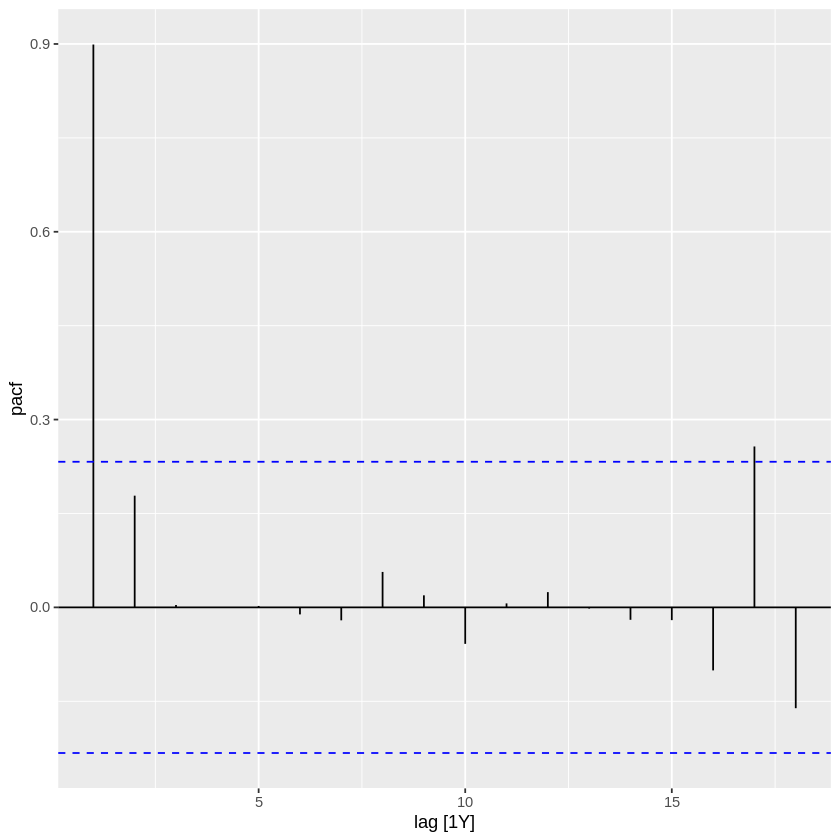

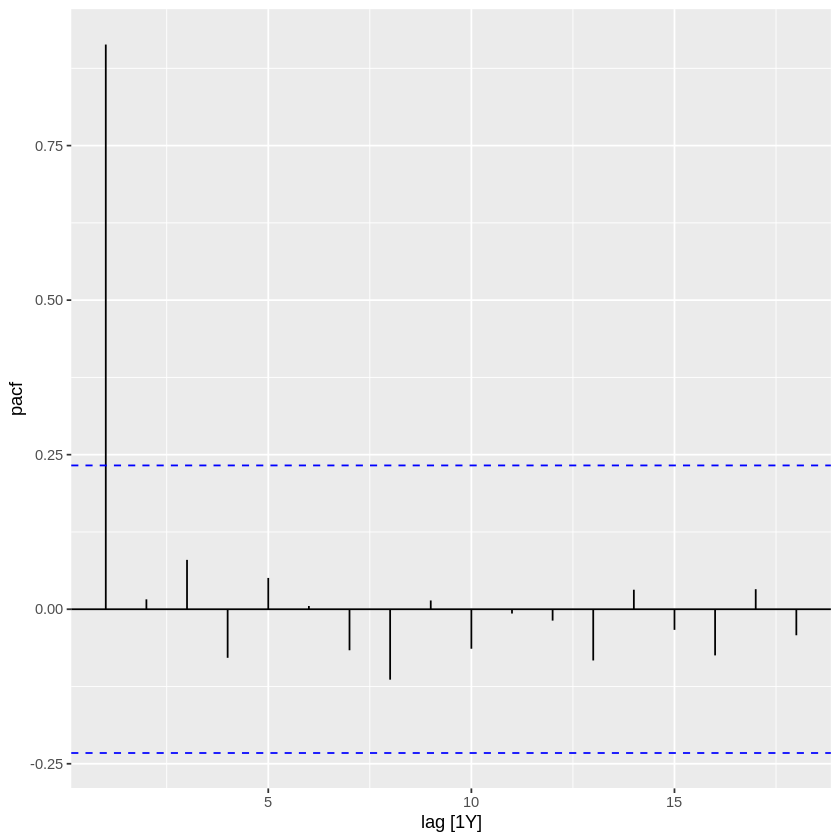

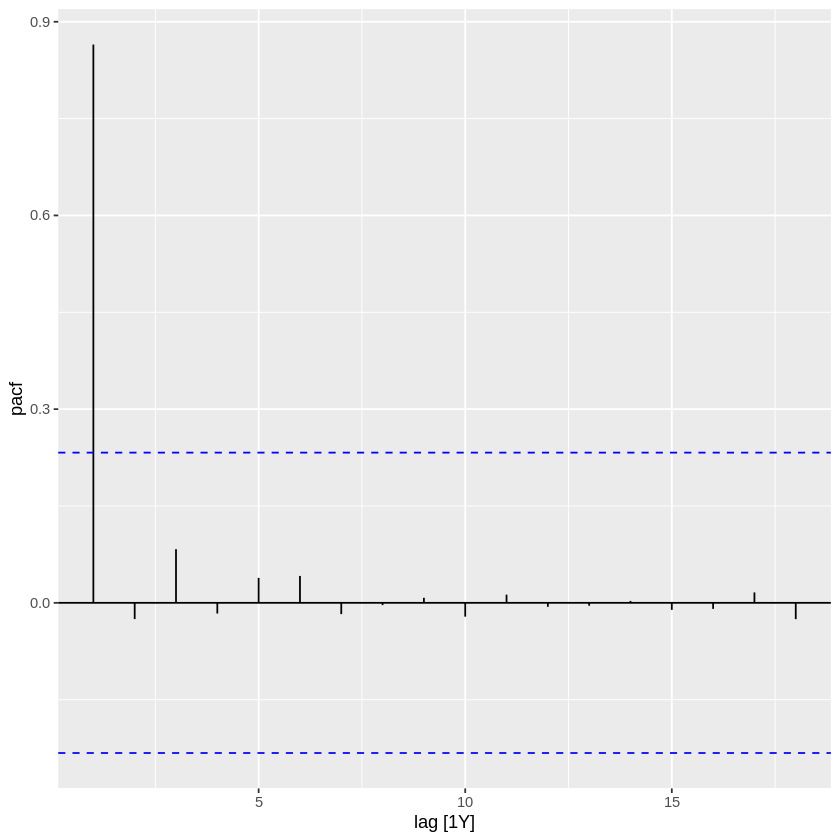

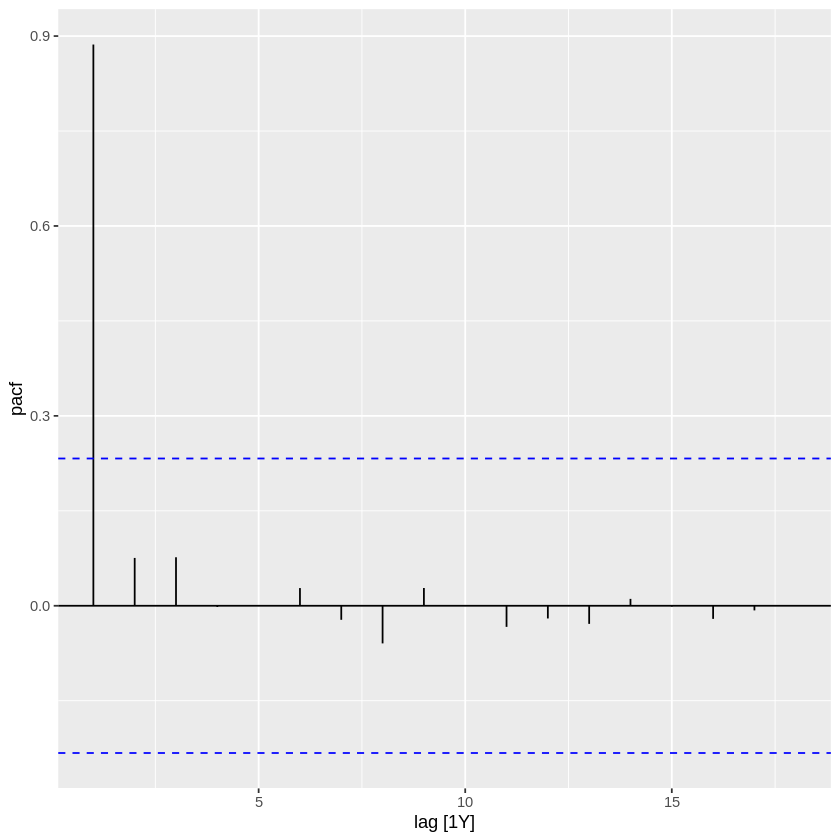

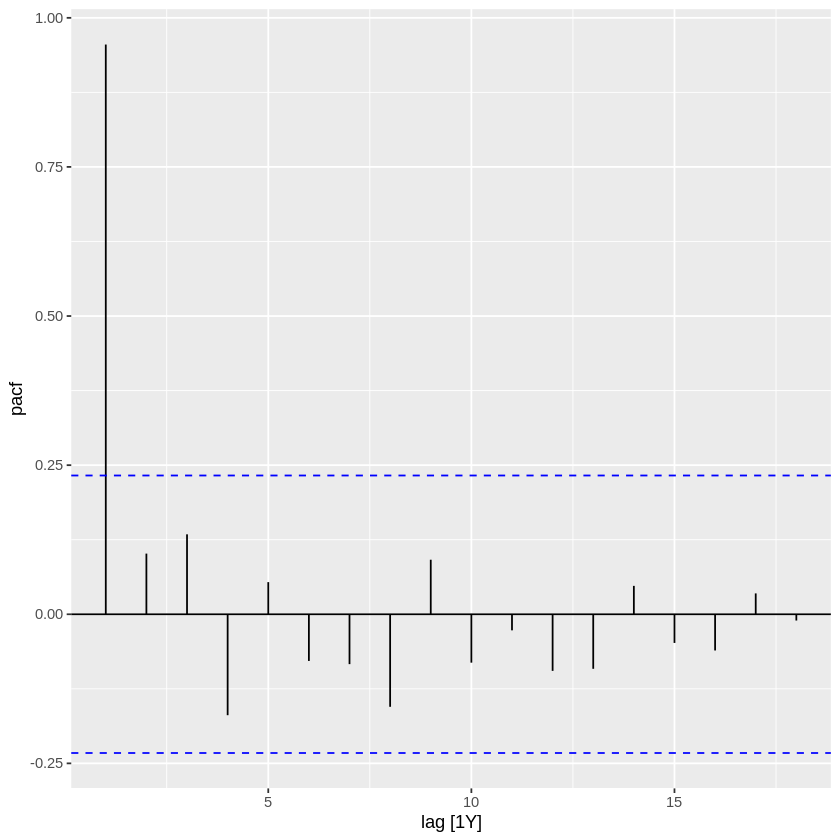

In [ ]:
# 偏自己相関のグラフ
pop_tsibble4 |>
  PACF( Birth ) |>
  autoplot()
pop_tsibble4 |>
  PACF( Dr ) |>
  autoplot()
pop_tsibble4 |>
  PACF( Dru14 ) |>
  autoplot()
pop_tsibble4 |>
  PACF( Drm ) |>
  autoplot()
pop_tsibble4 |>
  PACF( Dro65 ) |>
  autoplot()

# 手順３　学習データと予測データの分類

２０１５年までの人口データと２０１４年までの出生、死亡データを学習データとし、  
その後５年間のデータを予測データとします。

In [ ]:
# 学習データと予測データ
prow_test2 = 6
prow_train2 = nrow( pop_tsibble4 ) - prow_test2

pop_tsibble4 |>
  tail( n = prow_test2 ) ->
pop_test4

pop_tsibble4 |>
  head( n = prow_train2 ) ->
pop_train4

# 手順４　ＡＲＩＭＡモデルによる予測

学習データを使ってＡＲＩＭＡモデルを推定していきます。  
まず、出生についてモデルを自動推定させ、ＡＩＣが＋２までのモデルを候補にします。

In [ ]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train4 |>
    model(
      arima = ARIMA( Birth,
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaB

max_AICB = min( trace_arimaB$AIC ) + 2
trace_arimaB |>
  filter( AIC < max_AICB ) 

Warning message:
“31 parsing failures.
row col expected actual         file
 14 AIC a number    Inf literal data
 15 AIC a number    Inf literal data
 16 AIC a number    Inf literal data
 17 AIC a number    Inf literal data
 18 AIC a number    Inf literal data
... ... ........ ...... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(1,1,0)(0,0,0)[1]+c",1661.006
"ARIMA(3,1,0)(0,0,0)[1]+c",1661.357
"ARIMA(4,1,0)(0,0,0)[1]+c",1660.440
"ARIMA(5,1,0)(0,0,0)[1]+c",1661.660
"ARIMA(2,1,1)(0,0,0)[1]+c",1661.718
"ARIMA(3,1,1)(0,0,0)[1]+c",1660.910
"ARIMA(0,1,2)(0,0,0)[1]+c",1659.753
"ARIMA(4,1,0)(0,0,0)[1]",1660.324
"ARIMA(5,1,0)(0,0,0)[1]",1661.303


列挙されたモデルで６年後までを予測し、  
２０２０年の実測した出生数に最も近いモデルを採用することにします。

In [ ]:
pop_train4 |>
  model(
    arimaB110 = ARIMA( Birth ~ 0 + pdq( 1, 1, 0 )),
    arimaB310 = ARIMA( Birth ~ 0 + pdq( 3, 1, 0 )),
    arimaB410 = ARIMA( Birth ~ 0 + pdq( 4, 1, 0 )),
    arimaB510 = ARIMA( Birth ~ 0 + pdq( 5, 1, 0 )),
    arimaB211 = ARIMA( Birth ~ 0 + pdq( 2, 1, 1 )), 
    arimaB311 = ARIMA( Birth ~ 0 + pdq( 3, 1, 1 )),
    arimaB012 = ARIMA( Birth ~ 0 + pdq( 0, 1, 2 )),
    arimaB411 = ARIMA( Birth ~ 0 + pdq( 4, 1, 1 ))) ->
pop_arimaB

# ＡＲＩＭＡによる予測
pop_arimaB |>
  forecast( h = "6 years") ->
pop_arimaB_f
pop_arimaB_f |>
  filter( Year == 2020 ) 
pop_test4 |>
  select( Year, Birth ) |>
  tail( 1 )

.model,Year,Birth,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaB110,2020,"N(1e+06, 4.1e+10)",1009928.9
arimaB310,2020,"N(988679, 6.8e+10)",988679.1
arimaB410,2020,"N(964741, 7e+10)",964741.4
arimaB510,2020,"N(956386, 6.8e+10)",956386.0
arimaB211,2020,"N(970142, 6.9e+10)",970141.6
arimaB311,2020,"N(961711, 6.8e+10)",961710.9
arimaB012,2020,"N(1e+06, 4.9e+10)",1002913.3
arimaB411,2020,"N(956630, 6.8e+10)",956629.7


Year,Birth
<dbl>,<dbl>
2020,840835


出生では、ＡＲＩＭＡ（５，１，０）を採用する事にします。  
同様に、死亡について、年齢３区分に同じ作業を行います。

In [ ]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train4 |>
    model(
      arima = ARIMA( log( Dru14 ),
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaDru

max_AICDru = min( trace_arimaDru$AIC ) + 2
trace_arimaDru |>
  filter( AIC < max_AICDru ) 

Warning message:
“5 parsing failures.
row col  expected    actual         file
 27 AIC a number  A         literal data
 27 NA  2 columns 6 columns literal data
 28 NA  2 columns 1 columns literal data
 29 NA  2 columns 1 columns literal data
 30 NA  2 columns 1 columns literal data
”


symbol,AIC
<chr>,<dbl>
"ARIMA(2,2,0)(0,0,0)[1]",-190.2631
"ARIMA(3,2,0)(0,0,0)[1]",-188.3785
"ARIMA(4,2,0)(0,0,0)[1]",-188.9538
"ARIMA(2,2,1)(0,0,0)[1]",-188.6975
"ARIMA(2,2,3)(0,0,0)[1]",-188.4201


In [ ]:
pop_train4 |>
  model(
    arimaDru220 = ARIMA( log( Dru14 ) ~ 0 + pdq( 2, 2, 0 )),
    arimaDru320 = ARIMA( log( Dru14 ) ~ 0 + pdq( 3, 2, 0 )),
    arimaDru420 = ARIMA( log( Dru14 ) ~ 0 + pdq( 4, 2, 0 )),
    arimaDru221 = ARIMA( log( Dru14 ) ~ 0 + pdq( 2, 2, 1 )),
    arimaDru223 = ARIMA( log( Dru14 ) ~ 0 + pdq( 2, 2, 3 ))) ->
pop_arimaDru

# ＡＲＩＭＡによる予測
pop_arimaDru |>
  forecast( h = "6 years") ->
pop_arimaDru_f
pop_arimaDru_f |>
  filter( Year == 2020 ) 
pop_test4 |>
  select( Year, Dru14 ) |>
  tail( 1 )

.model,Year,Dru14,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaDru220,2020,"t(N(-8.8, 0.053))",0.0001529418
arimaDru320,2020,"t(N(-8.8, 0.051))",0.0001556596
arimaDru420,2020,"t(N(-8.7, 0.039))",0.0001679600
arimaDru221,2020,"t(N(-8.7, 0.042))",0.0001640318
arimaDru223,2020,"t(N(-8.7, 0.036))",0.0001780497


Year,Dru14
<dbl>,<dbl>
2020,0.0001803606


１４歳以下の死亡率では、ＡＲＩＭＡ（２，２，３）を採用する事にします。  

In [ ]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train4 |>
    model(
      arima = ARIMA( log( Drm ),
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaDrm

max_AICDrm = min( trace_arimaDrm$AIC ) + 2
trace_arimaDrm |>
  filter( AIC < max_AICDrm ) 

Warning message:
“11 parsing failures.
row col expected actual         file
 17 AIC a number    Inf literal data
 19 AIC a number    Inf literal data
 20 AIC a number    Inf literal data
 21 AIC a number    Inf literal data
 24 AIC a number    Inf literal data
... ... ........ ...... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(2,2,0)(0,0,0)[1]",-269.8485
"ARIMA(3,2,0)(0,0,0)[1]",-269.1453
"ARIMA(0,2,1)(0,0,0)[1]",-270.1746
"ARIMA(1,2,1)(0,0,0)[1]",-268.2093
"ARIMA(2,2,1)(0,0,0)[1]",-269.3848
"ARIMA(0,2,2)(0,0,0)[1]",-268.2427
"ARIMA(0,2,3)(0,0,0)[1]",-268.6563


In [ ]:
pop_train4 |>
  model(
    arimaDrm220 = ARIMA( log( Drm ) ~ 0 + pdq( 2, 2, 0 )),
    arimaDrm320 = ARIMA( log( Drm ) ~ 0 + pdq( 3, 2, 0 )),
    arimaDrm021 = ARIMA( log( Drm ) ~ 0 + pdq( 0, 2, 1 )),
    arimaDrm121 = ARIMA( log( Drm ) ~ 0 + pdq( 1, 2, 1 )),
    arimaDrm221 = ARIMA( log( Drm ) ~ 0 + pdq( 2, 2, 1 )),
    arimaDrm022 = ARIMA( log( Drm ) ~ 0 + pdq( 0, 2, 2 )),
    arimaDrm023 = ARIMA( log( Drm ) ~ 0 + pdq( 0, 2, 3 ))) ->
pop_arimaDrm

# ＡＲＩＭＡによる予測
pop_arimaDrm |>
  forecast( h = "6 years") ->
pop_arimaDrm_f
pop_arimaDrm_f |>
  filter( Year == 2020 ) 
pop_test4 |>
  select( Year, Drm ) |>
  tail( 1 )

.model,Year,Drm,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaDrm220,2020,"t(N(-6.6, 0.022))",0.001430613
arimaDrm320,2020,"t(N(-6.5, 0.017))",0.001488071
arimaDrm021,2020,"t(N(-6.4, 0.012))",0.001651129
arimaDrm121,2020,"t(N(-6.4, 0.012))",0.001656888
arimaDrm221,2020,"t(N(-6.5, 0.014))",0.001537052
arimaDrm022,2020,"t(N(-6.4, 0.012))",0.001661426
arimaDrm023,2020,"t(N(-6.4, 0.012))",0.001606034


Year,Drm
<dbl>,<dbl>
2020,0.001633071


１５歳以上６４歳以下の死亡率では、ＡＲＩＭＡ（０，２，３）を採用する事にします。  

In [ ]:
# ＡＩＣが自動推定＋２までのモデルを候補として列挙
capture.output({
  pop_train4 |>
    model(
      arima = ARIMA( log( Dro65 ),
                     ic = "aic",
                     trace = TRUE,
                     stepwise = FALSE ))
}) |>
  read_table( col_names = c( "symbol", "AIC" ),
              col_types = "cn",
              comment = "<" ) |>
  na.omit() ->
trace_arimaDro

max_AICDro = min( trace_arimaDro$AIC ) + 2
trace_arimaDro |>
  filter( AIC < max_AICDro ) 

Warning message:
“12 parsing failures.
row col expected actual         file
 14 AIC a number    Inf literal data
 16 AIC a number    Inf literal data
 21 AIC a number    Inf literal data
 24 AIC a number    Inf literal data
 40 AIC a number    Inf literal data
... ... ........ ...... ............
See problems(...) for more details.
”


symbol,AIC
<chr>,<dbl>
"ARIMA(2,1,2)(0,0,0)[1]+c",-243.0650
"ARIMA(0,1,3)(0,0,0)[1]+c",-244.8596
"ARIMA(1,1,3)(0,0,0)[1]+c",-244.1382
"ARIMA(0,1,4)(0,0,0)[1]+c",-244.2600


In [ ]:
pop_train4 |>
  model(
    arimaDro212 = ARIMA( log( Dro65 ) ~ 0 + pdq( 2, 1, 2 )),
    arimaDro013 = ARIMA( log( Dro65 ) ~ 0 + pdq( 0, 1, 3 )),
    arimaDro113 = ARIMA( log( Dro65 ) ~ 0 + pdq( 1, 1, 3 )),
    arimaDro014 = ARIMA( log( Dro65 ) ~ 0 + pdq( 0, 1, 4 ))) ->
pop_arimaDro

# ＡＲＩＭＡによる予測
pop_arimaDro |>
  forecast( h = "6 years") ->
  pop_arimaDro_f
pop_arimaDro_f |>
  filter( Year == 2020 ) 
pop_test4 |>
  select( Year, Dro65 ) |>
  tail( 1 )


.model,Year,Dro65,.mean
<chr>,<dbl>,<dist>,<dbl>
arimaDro212,2020,"t(N(-3.4, 0.0065))",0.03430640
arimaDro013,2020,"t(N(-3.4, 0.0045))",0.03482426
arimaDro113,2020,"t(N(-3.4, 0.0056))",0.03453209
arimaDro014,2020,"t(N(-3.4, 0.0051))",0.03462465


Year,Dro65
<dbl>,<dbl>
2020,0.03462459


６５歳以上の死亡率では、ＡＲＩＭＡ（０，１，４）を採用する事にします。  

# 手順５　出生数、死亡率から総人口を計算

昨年の人口＋出生－死亡を計算します。

In [ ]:
# 出生数、死亡数の合算
pop_test4 |>
  rename( "forecast_BD" = Total ) ->
pop_arima_f4

pop_arimaB_f |>
  as.data.frame() |>
  filter( .model == "arimaB510" ) |>
  select( .mean ) ->
pop_arima_f4[, 3 ]

pop_arimaDru_f |>
  as.data.frame() |>
  filter( .model == "arimaDru223" ) |>
  select( "Dru" = .mean ) ->
pop_arima_f4[, 12 ]

pop_arimaDrm_f |>
  as.data.frame() |>
  filter( .model == "arimaDrm023" ) |>
  select( "Drm" = .mean ) ->
pop_arima_f4[, 13 ]

pop_arimaDro_f |>
  as.data.frame() |>
  filter( .model == "arimaDro014" ) |>
  select( "Dro" = .mean ) ->
pop_arima_f4[, 14 ]

pop_arima_f4 |>
  mutate( Du14 = Tu14  * Dru14,
          Dm = Tm * Drm,
          Do65 = To65 * Dro65,
          forecast_BD = lag( forecast_BD +
                               Birth -
                               Du14 -
                               Dm - 
                               Do65 )) ->
pop_arima_f4

# 手順６　結果比較

それでは、実データや「本家」社会保障人口問題研究所の推計結果と比較してみます。

Year,Total,forecast_BD,DMBM,DMBH,DLBM,DLBH
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,126933000,126758027,126838000,126864000,126912000,126938000
2017,126706000,126551256,126532000,126605000,126704000,126777000
2018,126443000,126321652,126177000,126315000,126441000,126580000
2019,126167000,126051668,125773000,125998000,126125000,126351000
2020,126146000,125761219,125325000,125658000,125761000,126094000


Plot variable not specified, automatically selected `.vars = Birth`


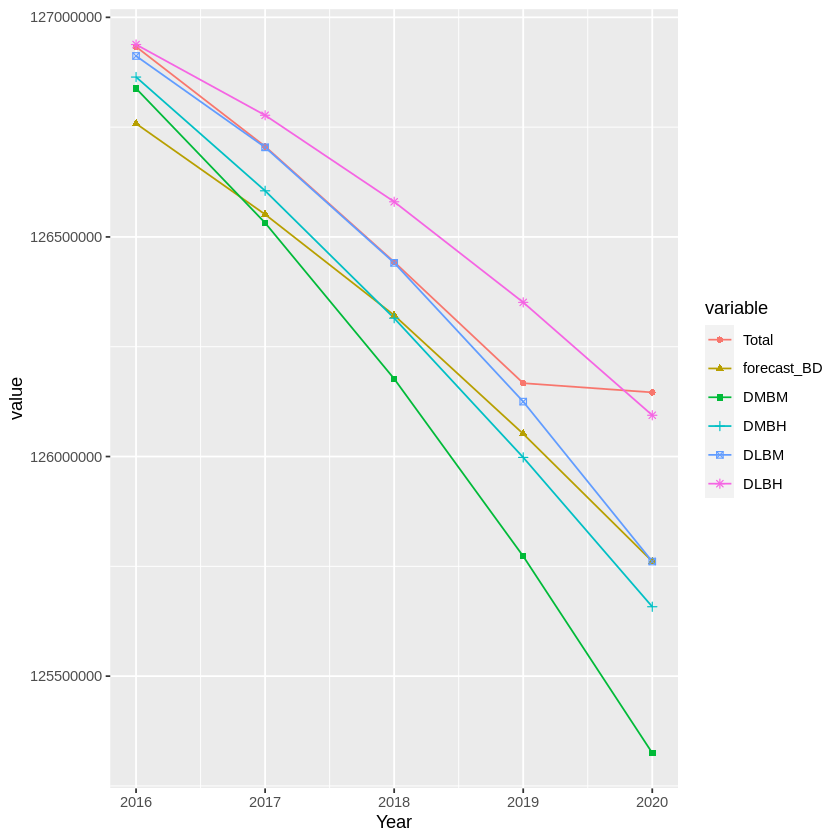

Plot variable not specified, automatically selected `.vars = Dru14`


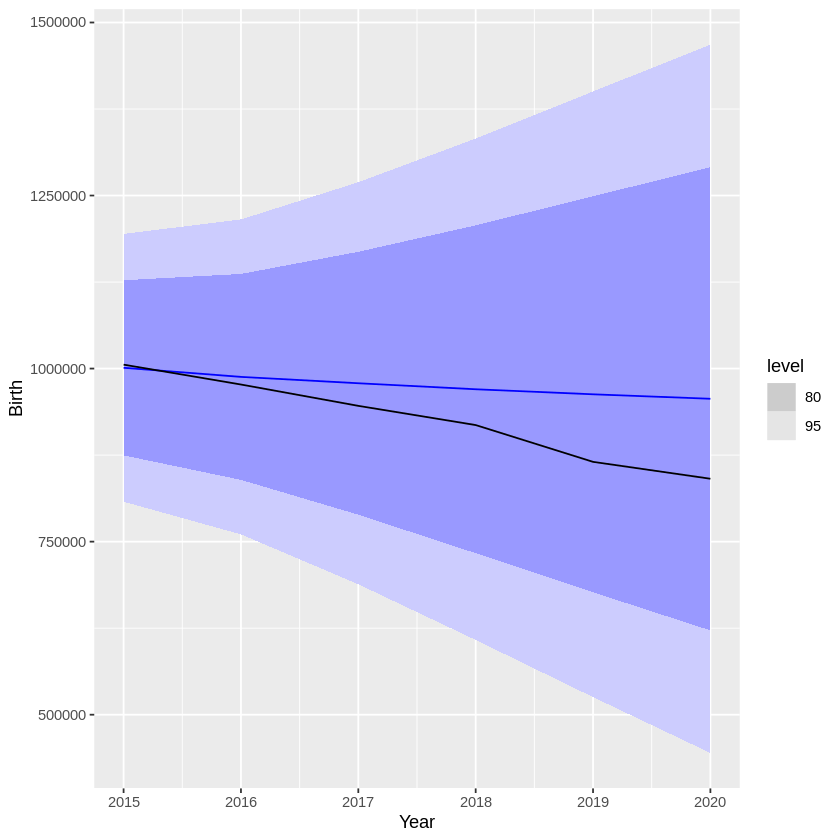

Plot variable not specified, automatically selected `.vars = Drm`


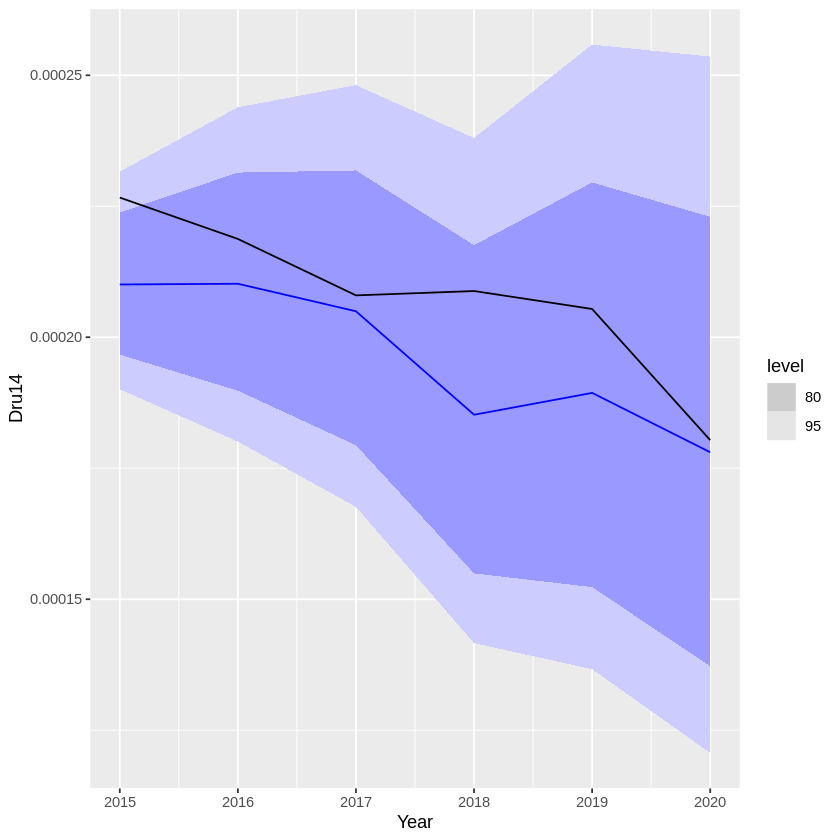

Plot variable not specified, automatically selected `.vars = Dro65`


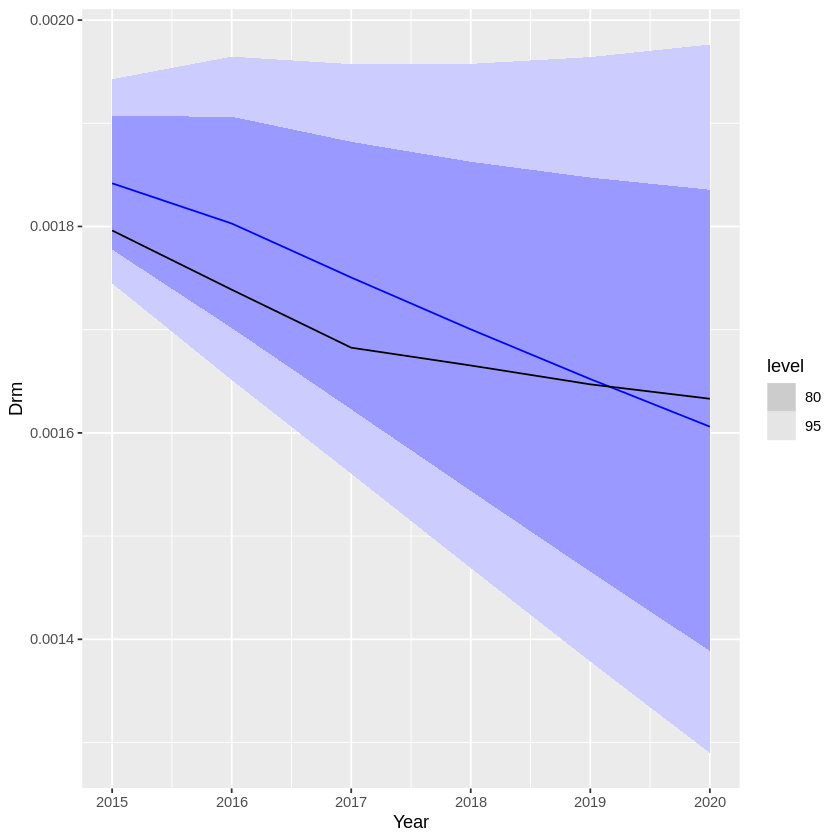

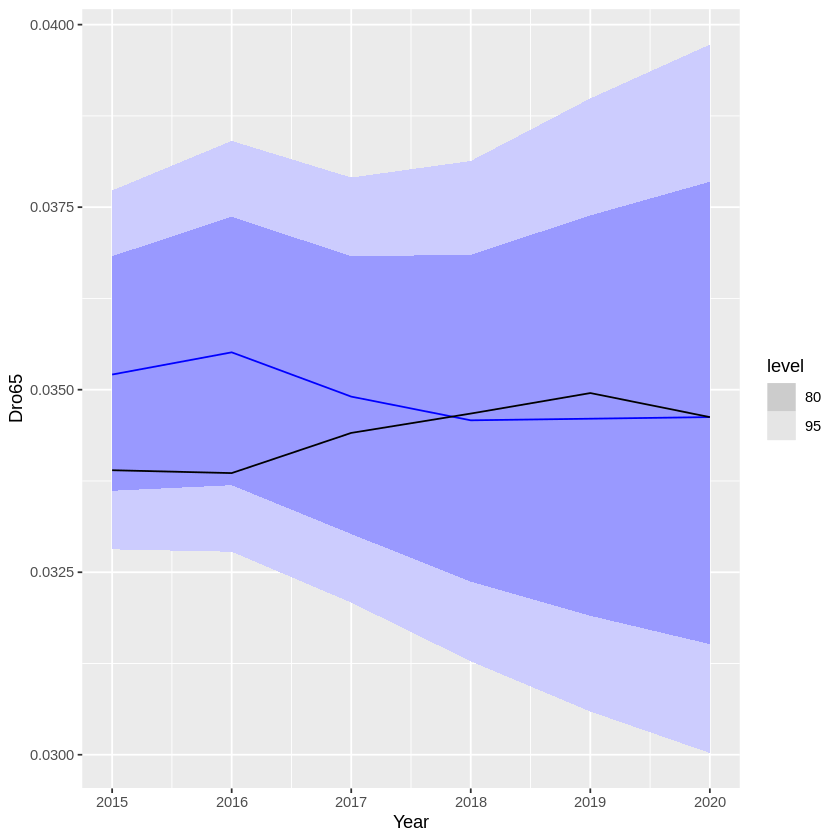

In [ ]:
# 社人研予測との比較
# 該当ＵＲＬを変数に格納
ipssURL = 
  c( "main/data/forecast_ipss.csv" )

repo |>
  paste0( ipssURL ) |>                    # 読み込むアドレスの編集
  read_csv( show_col_types = FALSE ) |>   # ネット上のファイル読み込み
  as_tsibble( index = Year ) ->           # ＴＳＩＢＢＬＥライブラリに変換
ipss_test

pop_arima_f4[ ,1:2 ] |>
  inner_join( pop_test4, by = "Year") |>
  inner_join( ipss_test, by = "Year") |>
  select( Year,
          Total,
          forecast_BD,
          DMBM,
          DMBH,
          DLBM,
          DLBH ) ->
join_test4
join_test4

# ライブラリの読み込み
library( reshape2 )

# 描画
join_test4 |> 
  melt(id = "Year",
       measure = c( "Total",
                    "forecast_BD",
                    "DMBM",
                    "DMBH",
                    "DLBM",
                    "DLBH")) |>
  ggplot( aes(x = Year,
              y = value,
              shape = variable,
              colour = variable,
              group = variable )) +
  geom_line() +
  geom_point()

pop_test4 |>
  select( Year, Birth ) ->
pop_testB

pop_arimaB_f |>
  filter( .model == "arimaB510" ) |>
  autoplot() +
  autolayer( pop_testB )

pop_test4 |>
  select( Year, Dru14 ) ->
pop_testDru

pop_arimaDru_f |>
  filter( .model == "arimaDru223" ) |>
  autoplot() +
  autolayer( pop_testDru )

pop_test4 |>
  select( Year, Drm ) ->
  pop_testDrm

pop_arimaDrm_f |>
  filter( .model == "arimaDrm023" ) |>
  autoplot() +
  autolayer( pop_testDrm )

pop_test4 |>
  select( Year, Dro65 ) ->
  pop_testDro

pop_arimaDro_f |>
  filter( .model == "arimaDro014" ) |>
  autoplot() +
  autolayer( pop_testDro )

今度も少し低めに出てしまいました。  
死亡率の影響はわずかだったようです。

# 次のステップ


*   同じ事をPythonでやってみる。　->　[ Python_ARIMA_4 ](https://colab.research.google.com/drive/1lgXdk2FnCO9Onn05Yje_xcpaJSoJQC3J?usp=sharing)
*   同じ事を状態空間モデルでやってみる。　->　 [ R_StateSpace_4 ](https://colab.research.google.com/drive/1RWv6l-nqpU4lqMMpbG1D-Sof-95_H5jg?usp=sharing) 
*   人口３区分でコホート分析する　->　こちら
